In [1]:
import numpy as np
import pandas as pd
from random import randint
from scipy import stats
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_auc_score,average_precision_score

import keras as kr
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [2]:
df = pd.read_csv('Churn_Modelling.csv')
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


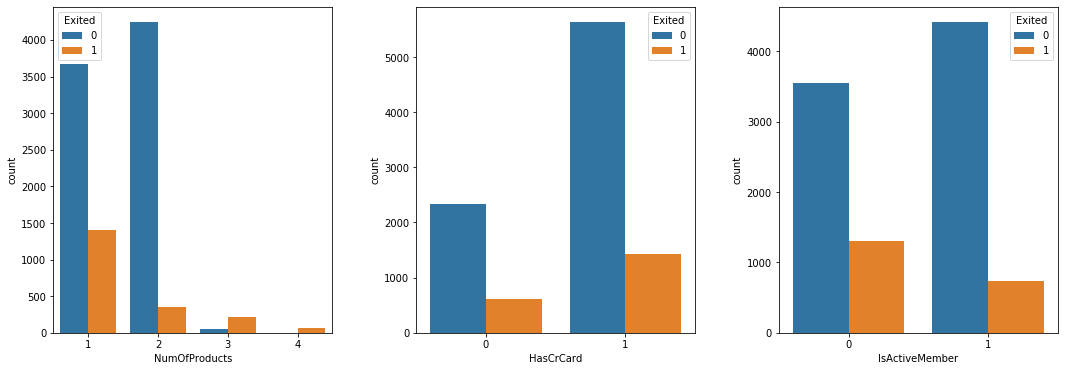

In [3]:
_, ax = plt.subplots(1, 3, figsize=(18, 6))
plt.subplots_adjust(wspace=0.3)
sns.countplot(x = "NumOfProducts", hue="Exited", data = df, ax= ax[0])
sns.countplot(x = "HasCrCard", hue="Exited", data = df, ax = ax[1])
sns.countplot(x = "IsActiveMember", hue="Exited", data = df, ax = ax[2])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [5]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [6]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [8]:
print(df['Geography'].unique().sum())
print(df['Gender'].unique().sum())

FranceSpainGermany
FemaleMale


In [9]:
df['Geography'] = df['Geography'].apply(lambda x: 0 if x=='France' else (1 if x=='Spain' else 2))
df['Gender'] = df['Gender'].apply(lambda x: 0 if x=='Female' else 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  int64  
 2   Gender           10000 non-null  int64  
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 859.5 KB


In [10]:
corr_matrix = df.corr()
corr_matrix

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,0.008267,-0.002857,-0.003965,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Geography,0.008267,1.000000,-0.016936,0.048092,0.001418,0.348700,-0.006180,0.004036,-0.012692,0.007382,0.153771
Gender,-0.002857,-0.016936,1.000000,-0.027544,0.014733,0.012087,-0.021859,0.005766,0.022544,-0.008112,-0.106512
Age,-0.003965,0.048092,-0.027544,1.000000,-0.009997,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,0.000842,0.001418,0.014733,-0.009997,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784,-0.014001
Balance,0.006268,0.348700,0.012087,0.028308,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.012238,-0.006180,-0.021859,-0.030680,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,-0.005458,0.004036,0.005766,-0.011721,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.025651,-0.012692,0.022544,0.085472,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.001384,0.007382,-0.008112,-0.007201,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097


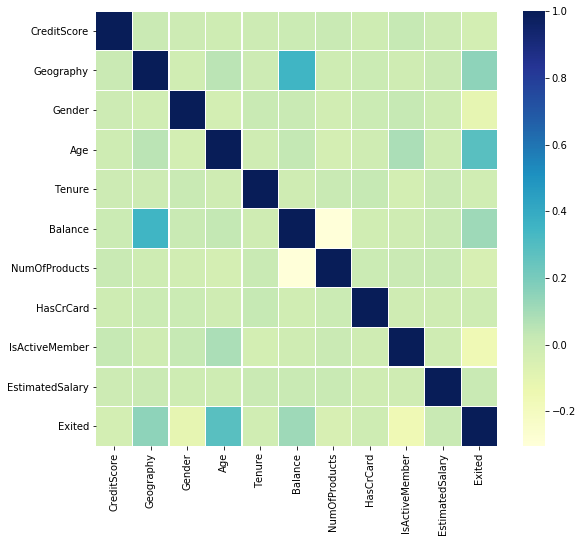

In [11]:
fig, ax = plt.subplots(figsize = (9,8))
sns.heatmap(corr_matrix, ax=ax, cmap='YlGnBu', linewidths=0.1)

In [12]:
X = df[['CreditScore','Geography','Gender', 'Age', 'Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary']]
Y=df[['Exited']]

In [13]:
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,0,0,42,2,0.00,1,1,1,101348.88
1,608,1,0,41,1,83807.86,1,0,1,112542.58
2,502,0,0,42,8,159660.80,3,1,0,113931.57
3,699,0,0,39,1,0.00,2,0,0,93826.63
4,850,1,0,43,2,125510.82,1,1,1,79084.10


In [14]:
Y.head()

,Exited
0,1
1,0
2,1
3,0
4,0


In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [16]:
model = Sequential()
model.add(Dense(100, input_dim=10, activation='tanh'))
model.add(Dense(15, input_dim=100, activation='tanh'))
model.add(Dense(1, activation='tanh'))

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=10, batch_size=10)

Epoch 1/10
8000/8000 [==============================] - 3s 411us/step - loss: 0.1839 - accuracy: 0.7763
Epoch 2/10
8000/8000 [==============================] - 4s 561us/step - loss: 0.1700 - accuracy: 0.7908
Epoch 3/10
8000/8000 [==============================] - 1s 120us/step - loss: 0.1688 - accuracy: 0.7920
Epoch 4/10
8000/8000 [==============================] - 1s 113us/step - loss: 0.1662 - accuracy: 0.7939
Epoch 5/10
8000/8000 [==============================] - 1s 113us/step - loss: 0.1669 - accuracy: 0.7924
Epoch 6/10
8000/8000 [==============================] - 1s 113us/step - loss: 0.1658 - accuracy: 0.7940
Epoch 7/10
8000/8000 [==============================] - 1s 112us/step - loss: 0.1655 - accuracy: 0.7939
Epoch 8/10
8000/8000 [==============================] - 1s 117us/step - loss: 0.1646 - accuracy: 0.7937
Epoch 9/10
8000/8000 [==============================] - 1s 114us/step - loss: 0.1637 - accuracy: 0.7943
Epoch 10/10
8000/8000 [==============================] - 1s 112u

In [17]:
Y_pred = model.predict(X_test)
Y_pred = (Y_pred >= 0.5)
#Y_test = (Y_test >= 0.5)

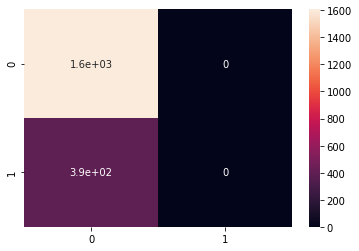

In [18]:

cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm,annot=True)

In [19]:
print("Accuracy : ",(cm[0][0]+cm[1][1])/(cm[0][0]+cm[1][1]+cm[1][0]+cm[0][1]))
print("Precision : ",(cm[0][0])/(cm[0][0]+cm[0][1]))
print("Recall : ",(cm[0][0])/(cm[0][0]+cm[1][0]))
ppp=(cm[0][0])/(cm[0][0]+cm[0][1]);rrr=(cm[0][0])/(cm[0][0]+cm[1][0]);fff=2*ppp*rrr/(ppp+rrr)
print("F1 score : ",fff)

Accuracy :  0.8035
Precision :  1.0
Recall :  0.8035
F1 score :  0.8910451899085111


In [20]:
scaler = StandardScaler()
df[['CreditScore']] = scaler.fit_transform(df[['CreditScore']])

In [21]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,-0.326221,0,0,42,2,0.00,1,1,1,101348.88,1
1,-0.440036,1,0,41,1,83807.86,1,0,1,112542.58,0
2,-1.536794,0,0,42,8,159660.80,3,1,0,113931.57,1
3,0.501521,0,0,39,1,0.00,2,0,0,93826.63,0
4,2.063884,1,0,43,2,125510.82,1,1,1,79084.10,0


In [22]:
df[['Geography']] = scaler.fit_transform(df[['Geography']])

In [23]:
df[['Gender']] = scaler.fit_transform(df[['Gender']])
df[['Age']] = scaler.fit_transform(df[['Age']])
df[['Tenure']] = scaler.fit_transform(df[['Tenure']])
df[['Balance']] = scaler.fit_transform(df[['Balance']])
df[['NumOfProducts']] = scaler.fit_transform(df[['NumOfProducts']])
df[['HasCrCard']] = scaler.fit_transform(df[['HasCrCard']])
df[['IsActiveMember']] = scaler.fit_transform(df[['IsActiveMember']])
df[['EstimatedSalary']] = scaler.fit_transform(df[['EstimatedSalary']])

In [24]:
X = df[['CreditScore','Geography','Gender', 'Age', 'Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary']]
Y=df[['Exited']]

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [26]:
model = Sequential()
model.add(Dense(15, input_dim=10, activation='tanh'))
model.add(Dense(15, input_dim=15, activation='tanh'))
model.add(Dense(1, activation='tanh'))

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=10, batch_size=10)

Epoch 1/10
8000/8000 [==============================] - 1s 121us/step - loss: 0.1646 - accuracy: 0.7843
Epoch 2/10
8000/8000 [==============================] - 1s 106us/step - loss: 0.1411 - accuracy: 0.8099
Epoch 3/10
8000/8000 [==============================] - 1s 108us/step - loss: 0.1360 - accuracy: 0.8174
Epoch 4/10
8000/8000 [==============================] - 1s 106us/step - loss: 0.1308 - accuracy: 0.8253
Epoch 5/10
8000/8000 [==============================] - 1s 105us/step - loss: 0.1244 - accuracy: 0.8374
Epoch 6/10
8000/8000 [==============================] - 1s 106us/step - loss: 0.1178 - accuracy: 0.8495
Epoch 7/10
8000/8000 [==============================] - 1s 130us/step - loss: 0.1140 - accuracy: 0.8556
Epoch 8/10
8000/8000 [==============================] - 1s 123us/step - loss: 0.1114 - accuracy: 0.8587
Epoch 9/10
8000/8000 [==============================] - 1s 132us/step - loss: 0.1095 - accuracy: 0.8575
Epoch 10/10
8000/8000 [==============================] - 1s 137u

In [27]:
Y_pred = model.predict(X_test)
Y_pred = (Y_pred >= 0.5)
#Y_test = (Y_test >= 0.5)

Accuracy :  0.86
Precision :  0.9607965152457997
Recall :  0.8767745599091425
F1 score :  0.9168646080760094


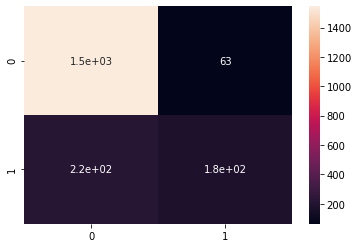

In [28]:
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm,annot=True)

print("Accuracy : ",(cm[0][0]+cm[1][1])/(cm[0][0]+cm[1][1]+cm[1][0]+cm[0][1]))
print("Precision : ",(cm[0][0])/(cm[0][0]+cm[0][1]))
print("Recall : ",(cm[0][0])/(cm[0][0]+cm[1][0]))
ppp=(cm[0][0])/(cm[0][0]+cm[0][1]);rrr=(cm[0][0])/(cm[0][0]+cm[1][0]);fff=2*ppp*rrr/(ppp+rrr)
print("F1 score : ",fff)